In [19]:
import pandas as pd
import random
import numpy as np
from numpy import linalg as LA


##################################################################################### COPULE DATA ###################################################################################

from scipy.io import arff
data = arff.loadarff('slump.arff')
df = pd.DataFrame(data[0])

covariables = df.iloc[:,0:7].values
response = df.iloc[:,7:10].values
positions = np.arange(103)

from sklearn.model_selection import train_test_split

covariables_train, covariables_test, response_train, response_test,positions_train,positions_test = train_test_split(covariables, response,positions, test_size=0.33, random_state=42)

####################################################################################################################################################################################
####################################################################################################################################################################################

#Pour le training, build training data
xtrain,ytrain = covariables_train, response_train

#Pour tester build test data
xtest,ytest = covariables_test, response_test 

In [12]:

#Pour tester build test data
#xtest,ytest = covariables_test, response_test 

Train_PottsData = xtrain

#Test_PottsData = xtest

q = 20
T =1000

sigma = 1

Initial_Spin_Configuration = []

for i in range(len(Train_PottsData)):
    
    Initial_Spin_Configuration.append(random.randint(1,q))


from collections import defaultdict
# function for adding edge to graph 
graph = defaultdict(list) 


# Python program to print connected  
# components in an undirected graph
#https://www.geeksforgeeks.org/connected-components-in-an-undirected-graph/
class Graph: 
      
    # init function to declare class variables 
    def __init__(self,V): 
        self.V = V 
        self.adj = [[] for i in range(V)] 
  
    def DFSUtil(self, temp, v, visited): 
  
        # Mark the current vertex as visited 
        visited[v] = True
  
        # Store the vertex to list 
        temp.append(v) 
  
        # Repeat for all vertices adjacent 
        # to this vertex v 
        for i in self.adj[v]: 
            if visited[i] == False: 
                  
                # Update the list 
                temp = self.DFSUtil(temp, i, visited) 
        return temp 
  
    # method to add an undirected edge 
    def addEdge(self, v, w): 
        self.adj[v].append(w) 
        self.adj[w].append(v) 
  
    # Method to retrieve connected components 
    # in an undirected graph 
    def connectedComponents(self): 
        visited = [] 
        cc = [] 
        for i in range(self.V): 
            visited.append(False) 
        for v in range(self.V): 
            if visited[v] == False: 
                temp = [] 
                cc.append(self.DFSUtil(temp, v, visited)) 
        return cc
    
# This code is contributed by Abhishek Valsan    


My_Potts_Graph = Graph(len(Train_PottsData))



from collections import OrderedDict

def findneighbors(i, Train_PottsData, Initial_Spin_Configuration, k_voisins = 10):
    
    Compute_Norms  = {}
    
    for j in range(len(Train_PottsData)):
        
        bond_ij_proba = 1 - np.exp(-(1/T)*(LA.norm(Train_PottsData[i,:] - Train_PottsData[j,:]))/(sigma))
        
        bond_ij = np.random.binomial(size=1, n=1, p=bond_ij_proba) 
        
        if (i != j and Initial_Spin_Configuration[i] == Initial_Spin_Configuration[j] and bond_ij[0]==1 ):
            
            Compute_Norms[j] = LA.norm(Train_PottsData[i,:] - Train_PottsData[j,:])
                                       

    OrderedCompute_Norms = OrderedDict(sorted(Compute_Norms.items(), key=lambda x: x[1]))

    OCN_size  = len(OrderedCompute_Norms)
    
    SelectedOrderedCompute_Norms = list(OrderedCompute_Norms)#[(OCN_size -k_voisins):OCN_size ]
                                       
    return SelectedOrderedCompute_Norms      


for i in range(len(Train_PottsData)):
    
    #let's get the top neighbors of observation i
    
    Selected_Neighbors = findneighbors(i, Train_PottsData, Initial_Spin_Configuration, k_voisins = 1)
    
    for j in Selected_Neighbors:
        
        #addEdge(graph,i,j)
        My_Potts_Graph.addEdge(i,j)


Potts_Clusters = My_Potts_Graph.connectedComponents() 

print(Potts_Clusters, "DONE")


def Compute_Partition (Train_PottsData, _Spin_Configuration, T=1, sigma=1):
    
    
    """ 
    
    Given the Data and Spin Configuration, this function compute the Partition
    
    Parameters : 
    ----------
    
    PottsData: the features data, X
    
    Initial_Spin_Configuration : Initial Spin configuration for all observations
    
    T : The temperature 
    
    sigma : The bandwitch
    
    """
    
    _My_Potts_Graph = Graph(len(Train_PottsData))
    
    for i in range(len(Train_PottsData)):
        #let's get the top neighbors of observation i

        Selected_Neighbors = findneighbors(i, Train_PottsData, _Spin_Configuration, k_voisins = 1)

        for j in Selected_Neighbors:

            #addEdge(graph,i,j)
            _My_Potts_Graph.addEdge(i,j)

                
    _Potts_Clusters = _My_Potts_Graph.connectedComponents() 
    
    return _Potts_Clusters

def Partitions_Clusters_Adjustments (New_Partition, Min_Cluster_Size):
    
    Copy_New_Partition = New_Partition.copy()
    
    List_of_clusters_size = [len(cluster)>Min_Cluster_Size for cluster in New_Partition]
    
    Somme_List_of_clusters_size = np.sum(List_of_clusters_size)
    
    
    if len(List_of_clusters_size)>0 and len(Copy_New_Partition)> Somme_List_of_clusters_size: 
        
        Position_Cluster_To_be_adjusted = List_of_clusters_size.index(0) 
        
        
        
    
    
    return adjusted_Partition


###Some supplementaries Code to adjust the clustering

import numpy as np
from numpy import linalg as LA

def ChangePartition(Partition, min_size):

    MyPartition = Partition.copy()
    
    max_iter = len(MyPartition)
    
    SearchCluster = [len(Cluster) > min_size for Cluster in MyPartition]
    
    if 0 in SearchCluster:
        ChooseTheFirstCluster = SearchCluster.index(0)

        distancelist = []
        
        for _i in range(max_iter):
                
                if _i!= ChooseTheFirstCluster:
                
                   distancelist.append(compute_distance(MyPartition[_i],MyPartition[ChooseTheFirstCluster]))
        
                else:
                     distancelist.append(0)   
                                       
        distancelist[ChooseTheFirstCluster] =  np.sum(distancelist)
                                       
        Cluster_To_MergeWith = np.argmin(distancelist)
                                       
        MyPartition[Cluster_To_MergeWith] = MyPartition[Cluster_To_MergeWith]+MyPartition[ChooseTheFirstCluster]
                                       
        del MyPartition[ChooseTheFirstCluster]
                                       
    return MyPartition                                   

def compute_distance(cluster1,cluster2):

    cluster_1 = cluster1.copy()
    cluster_2 = cluster2.copy()
    
    
    all_distances= []
    
    
    for j in cluster_1:
        
        all_distances.extend([LA.norm(Train_PottsData[j,:] - Train_PottsData[k,:]) for k in cluster_2])
        
        
    return float(np.min(all_distances))

def AdjustPartition(GeneratedPartition, min_cluster_size):
    
    NewPartition0 = GeneratedPartition

    NewPartition1 = ChangePartition(GeneratedPartition, 1)


    while NewPartition1 != NewPartition0:

          NewPartition0 = NewPartition1
            
          #Nous souhaitons ajuster les partitions à une taille de cluster minimum==5  
          NewPartitionAdj = ChangePartition(NewPartition0, min_cluster_size) 

          NewPartition1 = NewPartitionAdj

    return NewPartition1

###########
def Potts_Random_Partition (Train_PottsData, Initial_Partition = Potts_Clusters, Number_of_Random_Partitions = 1000) : 
    
    
    """ 
    
    This function generates _Random_Partitions for a given initial Potts_Clusters
    
    Parameters
    ----------
    
    Initial_Partition : A given initial (random partition) in defaultdict(list) format
    
    Number_of_Random_Partitions: Number of expected random partitions, must be greater than 0 preferably
    
    
    Return    
    ------
    
    Full_Observations_Spin_Configuration : A full list of spin configuration for each generated partition 
    
    Full_Partition_Sets : A full list of all generated partitions
    
    
    """
    
    Full_Observations_Spin_Configuration = defaultdict(list) 
    
    Full_Partition_Sets = defaultdict(list) 
    
    Actual_Partition = Initial_Partition
    
    k = 0
    
    while k < (Number_of_Random_Partitions + 1):
        
        
            #Create the Clustter Component spin configuration 

            _Cluster_Spin_Configuration = []

            for h in range(len(Actual_Partition)):

                _Cluster_Spin_Configuration.append(random.randint(1,q))

            #Find observation spin configuration

            Observations_Spin_Configuration = []

            for observation in range(len(Train_PottsData)):

                Observation_Cluster_index = [ int(observation in Cluster) for Cluster in  Actual_Partition ].index(1)

                Observations_Spin_Configuration.append(_Cluster_Spin_Configuration[Observation_Cluster_index])
            
            
            Full_Observations_Spin_Configuration[k] = Observations_Spin_Configuration
            
            
            New_Partition = Compute_Partition (Train_PottsData, Observations_Spin_Configuration, T=1, sigma=1)

            #print(New_Partition)
            
            AdjustedPartition = AdjustPartition(New_Partition,2)
            
            List_of_clusters_size = [len(cluster) for cluster in AdjustedPartition]
            
            if  int(np.min(List_of_clusters_size)) >= 1 : 
                
                                
                Full_Partition_Sets[k] = AdjustedPartition

                k = k + 1
                print("We are at step: %i"%k)
                print("Clusters Size of Current Partition", List_of_clusters_size)
                print("Partition is:", AdjustedPartition)
            Actual_Partition = AdjustedPartition
            
    return Full_Partition_Sets, Full_Observations_Spin_Configuration


import time
start_time = time.time()

NRP = 50

Partitions_Sets,Spin_Configuration_Sets = Potts_Random_Partition (Train_PottsData, Initial_Partition= Potts_Clusters, Number_of_Random_Partitions = NRP)

print("%i Partitions generated-- %s seconds ---DONE!" % (NRP, time.time() - start_time))

import pickle
output = open('slump_50_Partitions_constraints_2_Sets.pkl', 'wb')
pickle.dump(Partitions_Sets, output)
output.close()


[[0, 55], [1, 65, 3, 41, 68, 15], [2, 53, 27, 29], [4], [5, 32], [6, 31, 60, 51, 9, 8], [7], [10, 37, 23, 52, 48], [11], [12], [13, 50, 66, 44], [14], [16, 67, 18], [17, 24], [19], [20, 39, 63], [21, 61, 36, 49], [22, 56, 64], [25], [26, 58], [28, 40], [30], [33, 54, 62], [34], [35], [38, 59, 45], [42], [43], [46], [47], [57]] DONE
We are at step: 1
Clusters Size of Current Partition [23, 7, 10, 6, 7, 3, 3, 7, 3]
Partition is: [[1, 20, 3, 15, 63, 28, 39, 26, 58, 40, 65, 41, 68, 0, 55, 4, 5, 12, 19, 25, 27, 42, 66], [6, 9, 60, 8, 31, 51, 54], [10, 23, 11, 52, 37, 47, 48, 2, 43, 29], [13, 24, 17, 57, 32, 62], [16, 18, 67, 14, 35, 33, 53], [21, 61, 36], [22, 56, 64], [34, 46, 38, 59, 45, 44, 50], [49, 30, 7]]
We are at step: 2
Clusters Size of Current Partition [24, 10, 8, 5, 7, 3, 3, 6, 3]
Partition is: [[0, 27, 4, 41, 19, 5, 3, 28, 12, 40, 25, 39, 68, 58, 26, 1, 65, 55, 66, 15, 42, 20, 63, 17], [2, 29, 11, 23, 47, 52, 10, 37, 48, 43], [6, 31, 60, 54, 51, 8, 9, 38], [13, 32, 62, 57, 24],

We are at step: 23
Clusters Size of Current Partition [69]
Partition is: [[0, 16, 3, 22, 5, 51, 9, 57, 13, 8, 4, 49, 1, 21, 15, 11, 67, 2, 44, 14, 37, 20, 6, 34, 26, 10, 45, 12, 63, 7, 38, 30, 17, 59, 31, 19, 27, 41, 24, 25, 42, 23, 60, 33, 18, 65, 36, 28, 35, 52, 50, 32, 66, 29, 53, 39, 46, 64, 56, 48, 55, 40, 43, 62, 47, 61, 58, 54, 68]]
We are at step: 24
Clusters Size of Current Partition [69]
Partition is: [[0, 43, 2, 27, 6, 5, 1, 17, 3, 28, 9, 57, 7, 44, 8, 60, 21, 15, 4, 37, 16, 14, 13, 29, 22, 11, 62, 26, 42, 19, 18, 35, 30, 24, 23, 12, 48, 36, 51, 10, 34, 32, 31, 20, 58, 47, 33, 41, 38, 46, 40, 52, 50, 25, 54, 67, 49, 45, 53, 59, 56, 55, 39, 68, 65, 66, 61, 64, 63]]
We are at step: 25
Clusters Size of Current Partition [69]
Partition is: [[0, 31, 2, 61, 8, 55, 5, 35, 4, 42, 9, 7, 1, 41, 10, 3, 24, 6, 59, 13, 29, 16, 14, 17, 36, 20, 28, 11, 43, 22, 21, 68, 19, 39, 18, 51, 23, 12, 40, 32, 25, 49, 33, 26, 37, 27, 15, 30, 47, 52, 48, 34, 45, 38, 58, 50, 65, 56, 62, 53, 57, 46, 63,

We are at step: 47
Clusters Size of Current Partition [69]
Partition is: [[0, 25, 6, 1, 16, 8, 19, 3, 4, 31, 5, 48, 23, 11, 9, 7, 60, 20, 14, 49, 2, 61, 10, 56, 13, 65, 21, 15, 12, 47, 18, 63, 28, 40, 24, 17, 43, 30, 45, 35, 26, 52, 32, 27, 54, 29, 50, 34, 51, 22, 37, 66, 44, 46, 33, 36, 64, 39, 38, 55, 53, 57, 67, 62, 59, 41, 58, 68, 42]]
We are at step: 48
Clusters Size of Current Partition [69]
Partition is: [[0, 1, 2, 19, 4, 24, 5, 10, 3, 14, 13, 11, 27, 6, 58, 8, 20, 12, 46, 25, 18, 31, 28, 16, 29, 9, 15, 40, 21, 7, 44, 39, 37, 32, 35, 23, 54, 22, 30, 49, 26, 34, 62, 17, 48, 45, 36, 33, 59, 38, 65, 52, 43, 63, 55, 42, 60, 53, 47, 56, 66, 57, 68, 64, 67, 41, 50, 51, 61]]
We are at step: 49
Clusters Size of Current Partition [69]
Partition is: [[0, 16, 13, 1, 51, 10, 3, 26, 15, 28, 5, 2, 35, 31, 12, 6, 42, 11, 4, 24, 8, 39, 19, 63, 27, 20, 9, 7, 58, 21, 14, 37, 17, 66, 22, 46, 32, 18, 29, 23, 52, 41, 30, 55, 25, 48, 45, 40, 33, 57, 49, 36, 59, 56, 34, 47, 44, 64, 54, 38, 61, 50, 43,

In [3]:
def Partitions_Statistics (Partitions_Sets):
    
    #copy the partitions
    Partitions_sets_copy = Partitions_Sets.copy()
    
    # Number of data per cluster (NumbDC)
    NumbDC = []
    
    #Number of cluster per partition (NumbCPar)
    NumbCPar = []
    
    
    for k,partition in Partitions_sets_copy.items():
        
        clusters_size = List_of_clusters_size = [len(cluster) for cluster in partition]
        
        NumbDC.extend(clusters_size)
        
        NumbCPar.append(len(clusters_size))
        
    return    NumbDC, NumbCPar

In [13]:
NumbDC, NumbCPar = Partitions_Statistics (Partitions_Sets)

In [14]:
len(NumbDC)

117

In [15]:
np.mean(NumbDC)

30.076923076923077

In [16]:
np.mean(NumbCPar)

2.2941176470588234

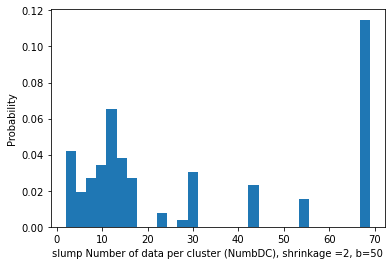

In [17]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
np.random.seed(42)
plt.hist(NumbDC, density=True, bins=30)  # `density=False` would make counts
plt.ylabel('Probability')
plt.xlabel('slump Number of data per cluster (NumbDC), shrinkage =2, b=50');

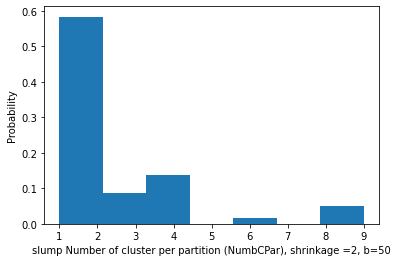

In [18]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
np.random.seed(42)
plt.hist(NumbCPar
         , density=True, bins=7)  # `density=False` would make counts
plt.ylabel('Probability')
plt.xlabel('slump Number of cluster per partition (NumbCPar), shrinkage =2, b=50');

In [20]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE
from sklearn.ensemble import RandomForestRegressor

In [22]:

############################################################
regressor = RandomForestRegressor(n_estimators = 10, max_depth=30, random_state = 0)
regressor.fit(covariables_train,response_train) 

# Predict the model 
rftestpred = regressor.predict(covariables_test) 
# Predict the model 
rftrainpred = regressor.predict(covariables_train)  
# xgboost test RMSE Computation 
rftestrmse = MSE(response_test, rftestpred)
print("test xgboost RMSE : % f" %(rftestrmse))

# xgboost test RMSE Computation 
rftrainrmse = MSE(response_train, rftrainpred) 
print("train xgboost RMSE : % f" %(rftrainrmse))


test xgboost RMSE :  137.295900
train xgboost RMSE :  16.407081


In [23]:

############################################################
regressor = RandomForestRegressor(n_estimators = 5, max_depth=10, random_state = 0)
regressor.fit(covariables_train,response_train) 

# Predict the model 
rftestpred = regressor.predict(covariables_test) 
# Predict the model 
rftrainpred = regressor.predict(covariables_train)  
# xgboost test RMSE Computation 
rftestrmse = MSE(response_test, rftestpred)
print("test xgboost MSE : % f" %(rftestrmse))

# xgboost test RMSE Computation 
rftrainrmse = MSE(response_train, rftrainpred)
print("train xgboost MSE : % f" %(rftrainrmse))

test xgboost MSE :  137.808608
train xgboost MSE :  20.329976
